In [1]:
%run util.py

In [ ]:
data_dir = '/home/jzh/Dropbox/Research/Anomaly_Detection/ROCHM/data_dir/'

In [2]:
N = 2
# N = 3
# N = 4
# N = 5

In [3]:
# mu_0: the initial distribution; 1 x (N**2) 
# mu: the actual stationary distribution; 1 x (N**2)
# mu_1: the estimated stationary distribution 
# P: the new transition matrix (the old transition matrix is Q)
# G_1: the estimate of the gradient
# H_1: the estimate of the Hessian
# U_1: an estimated sample path of the Gaussian random vector U; length 1000

mu_01, mu_1, mu_11, P_11, G_11, H_11, U_11 = ChainGen(N)  # P_11 is the 1st ground truth transition matrix
mu_02, mu_2, mu_12, P_12, G_12, H_12, U_12 = ChainGen(N)  # P_12 is the 2nd ground truth transition matrix
mu_03, mu_3, mu_13, P_13, G_13, H_13, U_13 = ChainGen(N)  # P_13 is the 3rd ground truth transition matrix

mu_04, mu_4, mu_14, P_14, G_14, H_14, U_14 = ChainGen(N)  # P_14 is a different transition matrix for testing purposes

saved_data = [mu_01, mu_1, mu_11, P_11, G_11, H_11, U_11, \
              mu_02, mu_2, mu_12, P_12, G_12, H_12, U_12, \
              mu_03, mu_3, mu_13, P_13, G_13, H_13, U_13, \
              mu_04, mu_4, mu_14, P_14, G_14, H_14, U_14]
zdump(saved_data, data_dir + 'P_11_12_13_14_%d.pkz'%N)

<string>:372: RuntimeWarning: covariance is not positive-semidefinite.


In [4]:
[mu_01, mu_1, mu_11, P_11, G_11, H_11, U_11, \
              mu_02, mu_2, mu_12, P_12, G_12, H_12, U_12, \
              mu_03, mu_3, mu_13, P_13, G_13, H_13, U_13, \
              mu_04, mu_4, mu_14, P_14, G_14, H_14, U_14] = zload(data_dir + 'P_11_12_13_14_%d.pkz'%N)

In [5]:
mu_1, mu_2, mu_3, mu_4

(array([ 0.135797  ,  0.18909217,  0.18909217,  0.48601866]),
 array([ 0.735991  ,  0.08119079,  0.08119079,  0.10162743]),
 array([ 0.07498231,  0.289983  ,  0.289983  ,  0.34505168]),
 array([ 0.29232326,  0.2631942 ,  0.2631942 ,  0.18128834]))

In [6]:
n_range = range(20, 50, 10)
# n_range = range(30, 90, 20)
# n_range = range(40, 130, 30)
# n_range = range(50, 170, 40)

In [7]:
num_test_sample = 4000
beta_list = list(np.arange(0, 0.2, 0.01)[1:-1]) + list(np.arange(0.2, 1.01, 0.05)[:-1])

In [8]:
eta_wc = {}
eta_Sanov = {}
test_sample = {}
for n in n_range:
    # Get sample paths of the Markov chain with length n; 
    # these paths will be the test set
    test_sample[str(n)] = []
    for idx in range(int(num_test_sample/4)):
        test_sample[str(n)].append(chain(mu_1, P_11, n))  
    for idx in range(int(num_test_sample/4)):
        test_sample[str(n)].append(chain(mu_2, P_12, n))  
    for idx in range(int(num_test_sample/4)):
        test_sample[str(n)].append(chain(mu_3, P_13, n))  
    for idx in range(int(num_test_sample/4)):
        test_sample[str(n)].append(chain(mu_4, P_14, n)) 
    # Get thresholds for Hoeffding's test corresponding to sample length n    
    for beta in beta_list:
        key = str(n) + '_' + str(beta)
        eta_1 = ThresWeakConvRobust(N, beta, n, mu_01, mu_1, mu_11, P_11, G_11, H_11, U_11, mu_02, mu_2, mu_12, P_12, G_12, H_12, U_12, mu_03, mu_3, mu_13, P_13, G_13, H_13, U_13).ThresCal()
        eta_2 = ThresSanov(N, beta, n, mu_01, mu_1, mu_11, P_11, G_11, H_11, U_11).ThresCal()
        eta_wc[key] = eta_1
        eta_Sanov[key] = eta_2
zdump([test_sample, eta_wc, eta_Sanov], data_dir + 'testSample_threshold_robust_%d.pkz'%N)

In [9]:
test_sample, eta_wc, eta_Sanov = zload(data_dir + 'testSample_threshold_robust_%d.pkz'%N)

In [10]:
from __future__ import division

mu_1 = np.reshape(mu_1, (N, N))
mu_2 = np.reshape(mu_2, (N, N))
mu_3 = np.reshape(mu_3, (N, N))

TPR_wc = {}
FPR_wc = {}
TPR_Sanov = {}
FPR_Sanov = {}

for n in n_range:
    for beta in beta_list:
        TP_wc = 0
        FP_wc = 0
        TP_Sanov = 0
        FP_Sanov = 0
        key = str(n) + '_' + str(beta)
        for idx in range(num_test_sample):
            KL1 = KL_est(test_sample[str(n)][idx], mu_1)
            KL2 = KL_est(test_sample[str(n)][idx], mu_2)
            KL3 = KL_est(test_sample[str(n)][idx], mu_3)
            KL = min([KL1, KL2, KL3])
            if idx > 3000 and KL > eta_wc[key]:
                TP_wc += 1
            if idx < 3000 and KL > eta_wc[key]:
                FP_wc += 1
            if idx > 3000 and KL > eta_Sanov[key]:
                TP_Sanov += 1
            if idx < 3000 and KL > eta_Sanov[key]:
                FP_Sanov += 1
        TPR_wc[key] = TP_wc / 1000
        FPR_wc[key] = FP_wc / 3000
        TPR_Sanov[key] = TP_Sanov / 1000
        FPR_Sanov[key] = FP_Sanov / 3000
        
zdump([TPR_wc, FPR_wc, TPR_Sanov, FPR_Sanov], data_dir + 'ROCpt_%d_robust.pkz'%N)

In [11]:
TPR_wc, FPR_wc, TPR_Sanov, FPR_Sanov = zload(data_dir + 'ROCpt_%d_robust.pkz'%N)

In [12]:
TPR_wc_list = {}
FPR_wc_list = {}
TPR_Sanov_list = {}
FPR_Sanov_list = {}
        
for n in n_range:
    TPR_wc_list[str(n)] = []
    FPR_wc_list[str(n)] = []
    TPR_Sanov_list[str(n)] = []
    FPR_Sanov_list[str(n)] = []
    TPR_wc_list[str(n)].append(0)
    FPR_wc_list[str(n)].append(0)
    TPR_Sanov_list[str(n)].append(0)
    FPR_Sanov_list[str(n)].append(0)
    for beta in beta_list:
        key = str(n) + '_' + str(beta)
        TPR_wc_list[str(n)].append(TPR_wc[key])
        FPR_wc_list[str(n)].append(FPR_wc[key])
        TPR_Sanov_list[str(n)].append(TPR_Sanov[key])
        FPR_Sanov_list[str(n)].append(FPR_Sanov[key])

    TPR_wc_list[str(n)].append(1)
    FPR_wc_list[str(n)].append(1)
    TPR_Sanov_list[str(n)].append(1)
    FPR_Sanov_list[str(n)].append(1)

/home/jzh/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


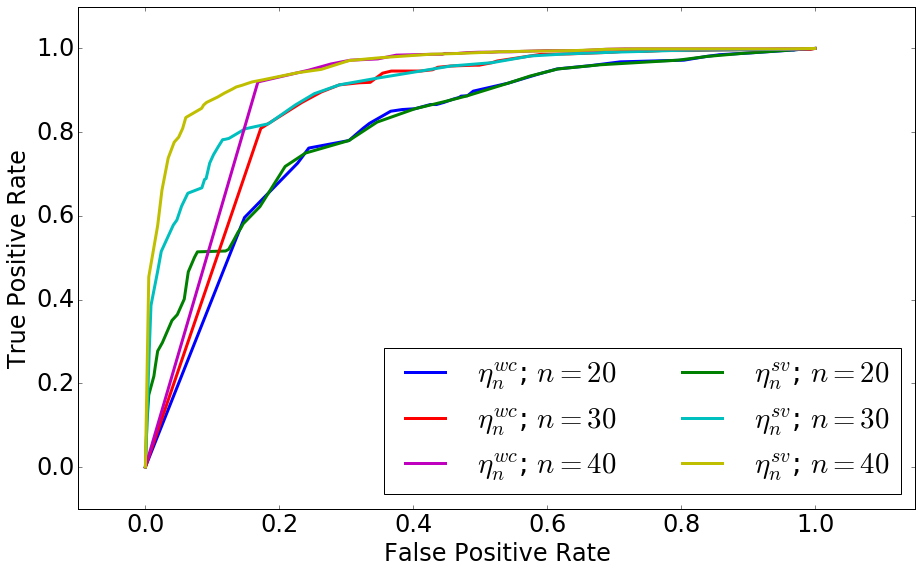

In [13]:
import matplotlib.pyplot as plt
import pylab
from pylab import *
%matplotlib inline  

ROC_WC_list = []
ROC_Sanov_list = []
style_list = ['b-', 'g-', 'r-', 'c-', 'm-', 'y-']
idx = 0

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 24}

plt.figure(figsize=(15,9))

matplotlib.rc('font', **font)

pylab.xlim(-0.1, 1.15)
pylab.ylim(-0.1, 1.1)

for n in n_range:
    ROC_WC_list.append(plt.plot(FPR_wc_list[str(n)], TPR_wc_list[str(n)], style_list[idx], linewidth=3))
    ROC_Sanov_list.append(plt.plot(FPR_Sanov_list[str(n)], TPR_Sanov_list[str(n)], style_list[idx+1], linewidth=3))
    idx += 2

legend_list_1 = []
legend_list_2 = []
legend_list_1.append(ROC_WC_list)
legend_list_1.append(ROC_Sanov_list)
legend_list_1 = list(np.array(legend_list_1).ravel())

for n in n_range:
    legend_list_2.append("$\eta_n^{wc}$; $n=%d$"%n)
for n in n_range:
    legend_list_2.append("$\eta_n^{sv}$; $n=%d$"%n)
plt.legend(legend_list_1, legend_list_2, ncol=2, loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.grid()

savefig(data_dir + 'ROC_%d_robust.eps'%N)
plt.show()